# Overview
Test optimal logistic regression on sliding window over image

# Imports

In [42]:
import random
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches


import json  
import mpl_toolkits
import os
import pickle
import glob
import re
import itertools
from PIL import Image
import time


from skimage import color
from skimage.feature import hog

from skimage.transform import pyramid_gaussian
from skimage.io import imread
from skimage.feature import hog

import cv2
import argparse as ap


import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc
from keras.utils import np_utils

from skimage.feature import hog
from skimage import data, color, exposure
from sklearn import cross_validation



import pyimagesearch.imutils as imutils
from pyimagesearch.helpers import pyramid
from pyimagesearch.helpers import sliding_window

# Read in data & make split

In [6]:
scene1 = mpimg.imread('shipsnet_data/scenes/lb_1.png')
scene2 = mpimg.imread('shipsnet_data/scenes/lb_2.png')
scene3 = mpimg.imread('shipsnet_data/scenes/lb_3.png')
scene4 = mpimg.imread('shipsnet_data/scenes/lb_4.png')
scene5 = mpimg.imread('shipsnet_data/scenes/sfbay_1.png')
scene6 = mpimg.imread('shipsnet_data/scenes/sfbay_2.png')
scene7 = mpimg.imread('shipsnet_data/scenes/sfbay_3.png')
scene8 = mpimg.imread('shipsnet_data/scenes/sfbay_4.png')

In [7]:
x_vect = pickle.load(open("x_vect.pkl", "rb"))
y_vect = pickle.load(open("y_vect.pkl", "rb"))
x_rot_vect = pickle.load(open("x_rot_vect.pkl", "rb"))
y_rot_vect = pickle.load(open("y_rot_vect.pkl", "rb"))

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(x_vect, y_vect, test_size=0.2, random_state = 1234, stratify = y_vect, shuffle = True)
xrot_train, xrot_test, yrot_train, yrot_test = train_test_split(x_rot_vect, y_rot_vect, test_size=0.2, random_state = 1234, stratify = y_rot_vect, shuffle = True)


# Optimize logreg

In [12]:
# Generate a confusion matrix plot: 
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def test_model(model, xtrain, ytrain, xtest, ytest):
    
    start_time = time.time()
    clf = model.fit(xtrain, ytrain)
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    y_true = ytest
    y_pred = clf.predict(xtest)
    y_score=clf.predict_proba(xtest)[:,1]
    fpr, tpr, thresh = roc_curve(ytest, y_score)
    roc_auc = auc(fpr, tpr)
    
    print(roc_auc)
    
    plt.figure()
    # Plotting our Baseline..
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')

    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    print ("Specificity:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[1, 0])))


    cm=confusion_matrix(y_true, y_pred, labels=None)

    plt.figure()
    plot_confusion_matrix(cm)

    print("--- %s seconds ---" % (time.time() - start_time))
    
    return clf

Training Data Accuracy: 1.00
Test Data Accuracy:     0.93
0.9749829931972789
[[399  21]
 [ 19 121]]


Precision:              0.95
Recall:                 0.95
Specificity:              0.86
--- 20.484987020492554 seconds ---


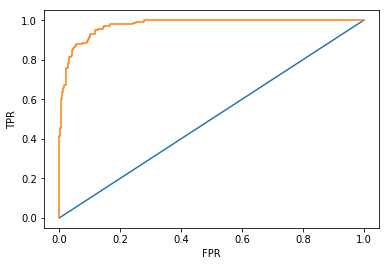

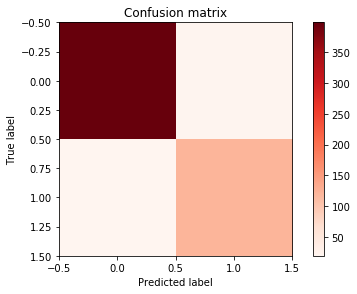

In [65]:
lr = LogisticRegression()
lr1 = test_model(lr, xtrain, ytrain, xtest, ytest)

# Run sliding window

In [56]:
def scan_image(model,image,stepSize,proba):
    (winW, winH) = (80, 80)
    output = []
    windows = []
    coords = []
    i = 0
    for (x, y, window) in sliding_window(image, stepSize=stepSize, windowSize=(winW, winH)):
        if window.shape[0] != winH or window.shape[1] != winW:
            continue
        x_image =np.ravel(window)
        y_pred_val = model.predict_proba(x_image.reshape(1, -1))[:,1]
        if y_pred_val > proba :
            windows.append(window)
            coords.append((x,y))
        i+=1
    output.append(windows)
    output.append(coords)
    return output

In [37]:
def plot_found(cnn_coords,image):
    fig,ax = plt.subplots(1)
    ax.imshow(image)

    for i in cnn_coords:
        rect = patches.Rectangle(i,80,80,linewidth=4,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [79]:
output = scan_image(lr1,scene1,50,.5)

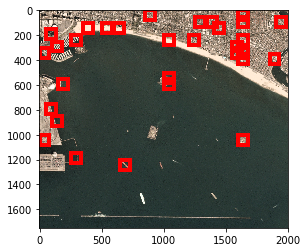

In [80]:
plot_found(output[1],scene1)